# Connect to Database

In [1]:
import psycopg2
import pandas as pd
import pandas.io.sql as pd_sql
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import yellowbrick as yb

from yellowbrick.features import RadViz
from sklearn.metrics import accuracy_score
from yellowbrick.features import Rank1D
from yellowbrick.features import Rank2D
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from yellowbrick.features import FeatureImportances
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LogisticRegression

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
def connectDB(DB):
    # connect to the PostgreSQL server
    return psycopg2.connect(
        database=DB,
        user="postgres",
        password="Georgetown16",
        host="database-1.c5vispb5ezxg.us-east-1.rds.amazonaws.com",
        port='5432')

def disconnectDB():
    cur.close()
    conn.close()

In [3]:
conn = connectDB("Dataset")

# extract everything from 'table_name' into a dataframe
df = pd_sql.read_sql(f"select * from public.\"FinalData_ForFeatures\" ", con=conn)
#code to be able to view all the columns in pandas dataframe
pd.set_option('display.max_columns', 50)       

# Feature Analysis for STEM 2013

In [4]:
df = df[['code_module', 
         'module_domain', 
         'module_presentation_length',
         'year',
         'term', 
         'num_of_prev_attempts',
         'final_result', 
         'date_registration', 
         'disability', 
         'gender', 
         'age_band', 
         'region', 
         'highest_education', 
         'imd_band', 
         'studied_credits', 
         'b4_sum_clicks', 
         'half_sum_clicks', 
         'std_half_score'
        ]]

In [5]:
feature_list = df

Filter out 2014 and Social Sciences

In [6]:
feature_list = df.loc[(df.year == 0)&(df.module_domain==1)]

In [7]:
#remove null values
#feature_list = feature_list.dropna()

In [8]:
feature_list.head()

,code_module,module_domain,module_presentation_length,year,term,num_of_prev_attempts,final_result,date_registration,disability,gender,age_band,region,highest_education,imd_band,studied_credits,b4_sum_clicks,half_sum_clicks,std_half_score
0,3,1,261,0,0,0,0,-68.0,0,0,2,3,3,9.0,60,0.0,0.0,0.000000
2,3,1,261,0,0,0,0,-137.0,0,0,2,2,3,3.0,90,81.0,565.0,58.166667
10,3,1,240,0,1,0,0,-128.0,0,1,0,1,2,4.0,90,0.0,0.0,0.000000
24,5,1,268,0,0,2,0,-47.0,0,0,1,8,3,8.0,60,111.0,367.0,14.666667
29,4,1,268,0,0,0,0,-61.0,0,0,1,9,1,0.0,30,0.0,0.0,0.000000


In [9]:
feature_list = feature_list[feature_list.columns.drop(['module_domain', 'year', 'term'])]

# Feature Selection

In [10]:
#pick out the 5 features to examine relationship
X = feature_list[["half_sum_clicks","gender", "highest_education", "code_module", "studied_credits"]].values
        
#define target variable
y = feature_list["final_result"].values

Radviz Visualization

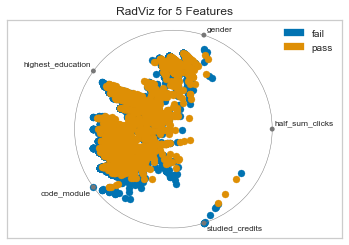

In [11]:
classes = ["fail", "pass"]
features = ["half_sum_clicks", "gender", "highest_education", "code_module", "studied_credits"]
        
sns.set_palette("colorblind")
# Instantiate the visualizer
visualizer = RadViz (
    classes=classes,
    features = features
)

visualizer.fit(X, y)           # Fit the data to the visualizer
visualizer.transform(X)        # Transform the data
visualizer.show()              # Draw the data

Pairplots: note that the hue is final_result which is now mapped to a binary classification

//anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
//anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


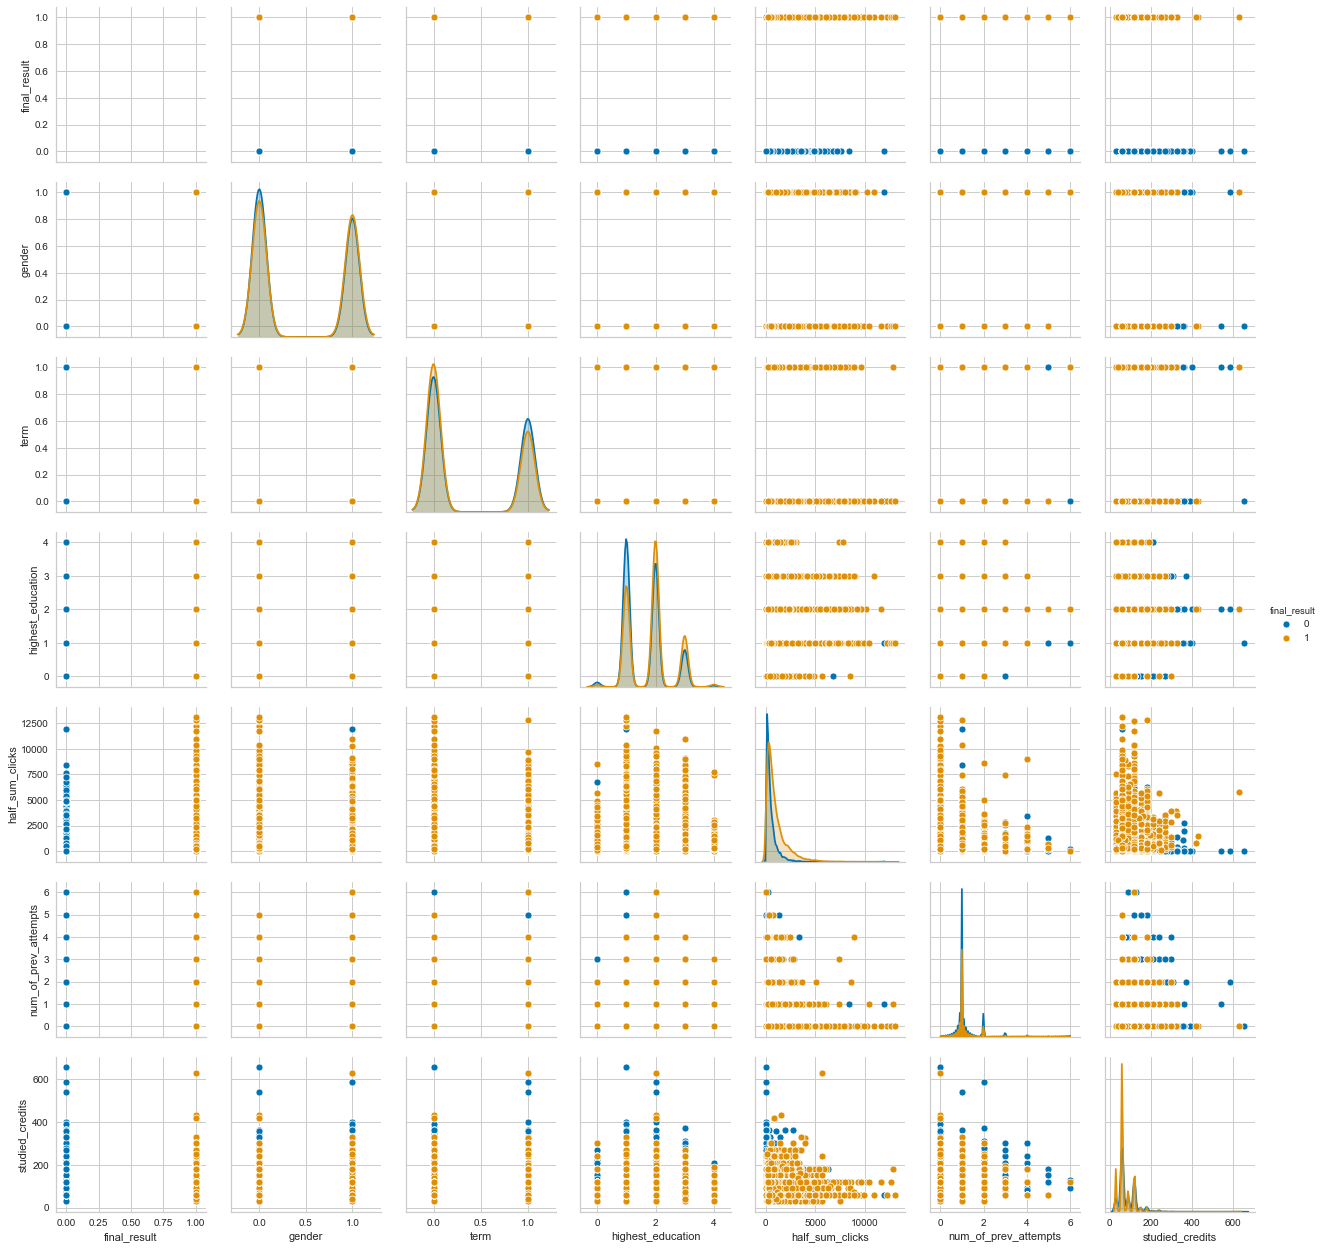

In [12]:
df_plot = df[["final_result","gender", "term", "highest_education", "half_sum_clicks","num_of_prev_attempts", "studied_credits"]]
g = sns.pairplot(df_plot, hue="final_result")
plt.show()

In [13]:
#printing out to check the y variable was filled
y

array([0, 0, 0, ..., 0, 1, 1])

# Feature Analysis Ranking

Shapiro Feature Ranking

//anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:1653: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
//anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:1653: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
//anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:1653: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
//anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:1653: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
//anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:1653: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
//anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:

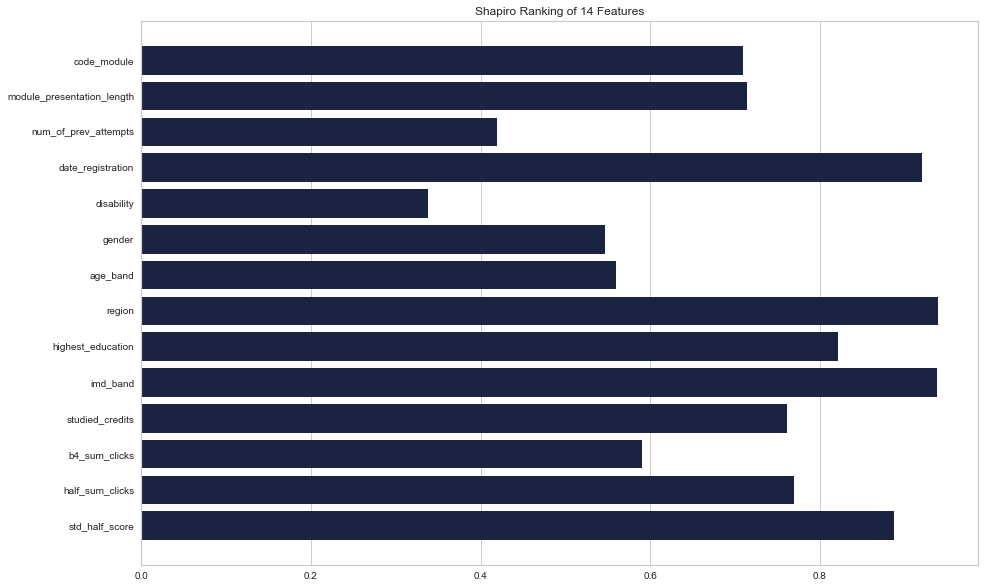

In [14]:
sns.set_palette("cubehelix")

X = feature_list[feature_list.columns.drop(['final_result'])]

y = feature_list['final_result']

# Instantiate the 1D visualizer with the Sharpiro ranking algorithm
visualizer = Rank1D(algorithm='shapiro',size=(1080, 720))

visualizer.fit(X, y)           # Fit the data to the visualizer
visualizer.transform(X)        # Transform the data
visualizer.show()              # Finalize and render the figure

RandomForest Classifier Feature Ranking

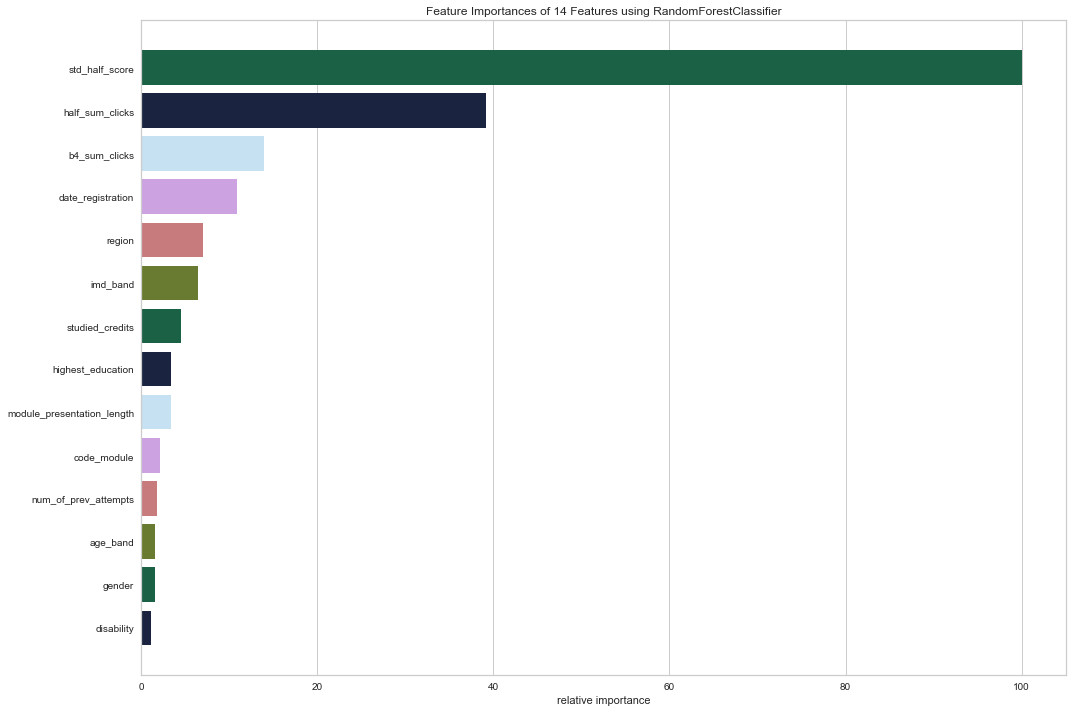

In [15]:
model = RandomForestClassifier(n_estimators=10)
feature_list = FeatureImportances(model, size=(1080, 720))
feature_list.fit(X, y)

feature_list.show()

LogisticRegression Feature Ranking

//anaconda3/lib/python3.7/site-packages/yellowbrick/model_selection/importances.py:195: YellowbrickWarning: detected multi-dimensional feature importances but stack=False, using mean to aggregate them.
  YellowbrickWarning,


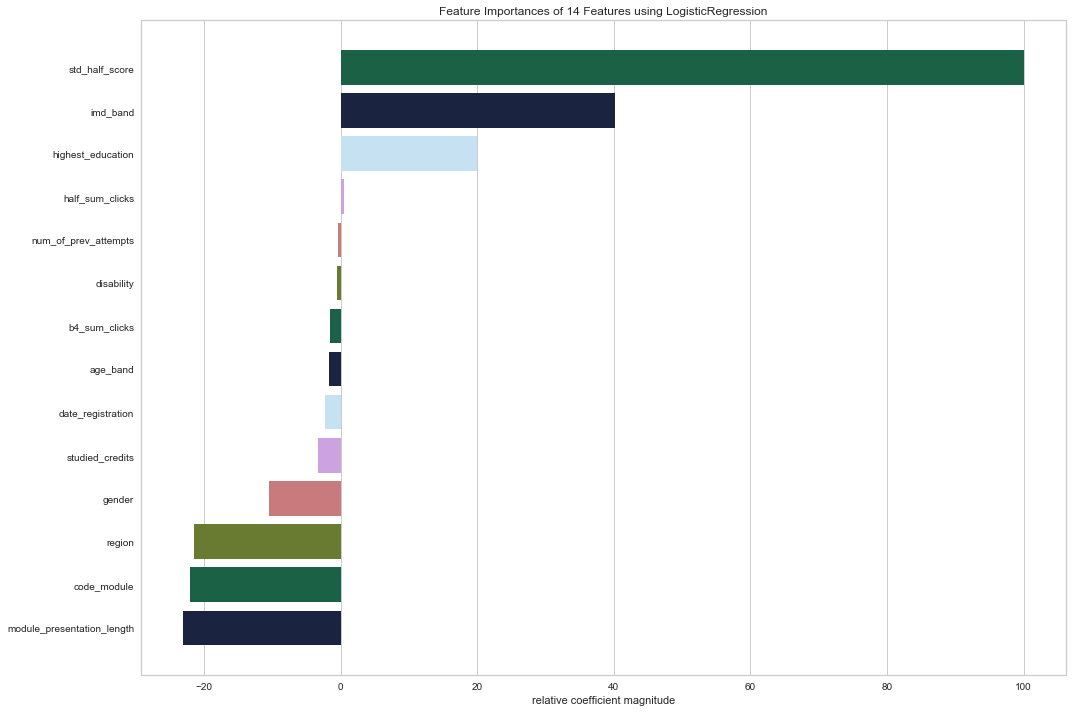

In [16]:
model = LogisticRegression()
viz = FeatureImportances(model, size=(1080, 720))

viz.fit(X, y)

viz.show()

DecisionTreeClassifier Feature Ranking

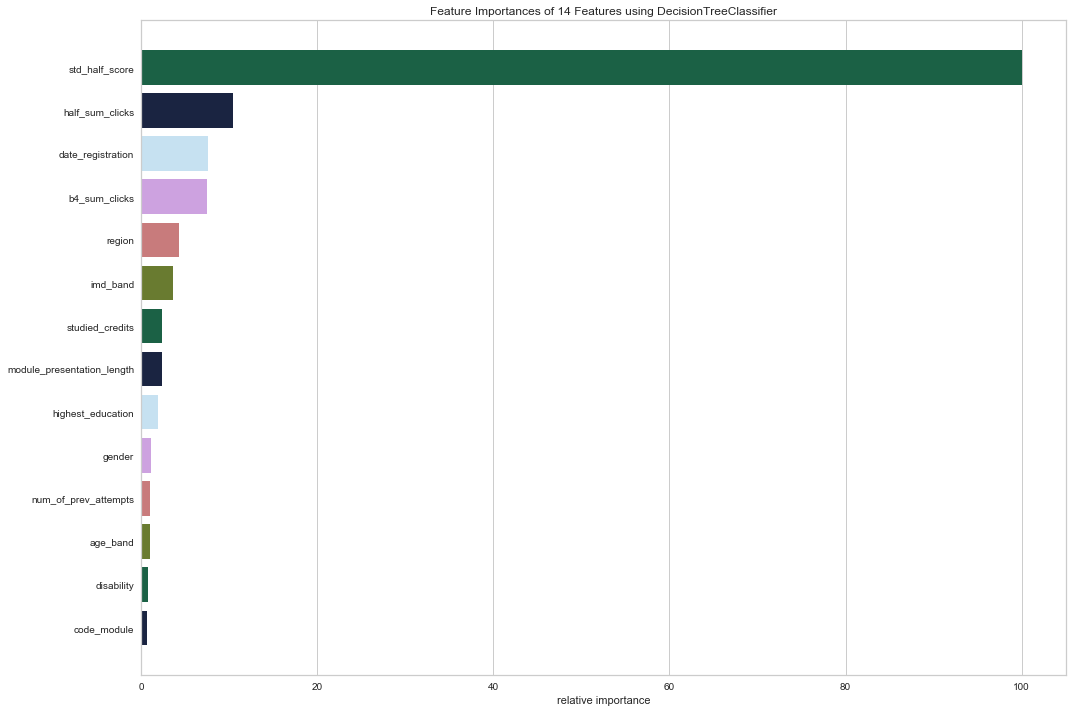

In [17]:
model = DecisionTreeClassifier()
viz = FeatureImportances(model, size=(1080, 720))

viz.fit(X, y)
viz.show()

In [18]:
feature_list = RandomForestClassifier()
feature_list.fit(X, y)
predictions = feature_list.predict(X)
    
accuracy_score(y, predictions)

0.9935782173131261

GradientBoostingClassifier Feature Ranking

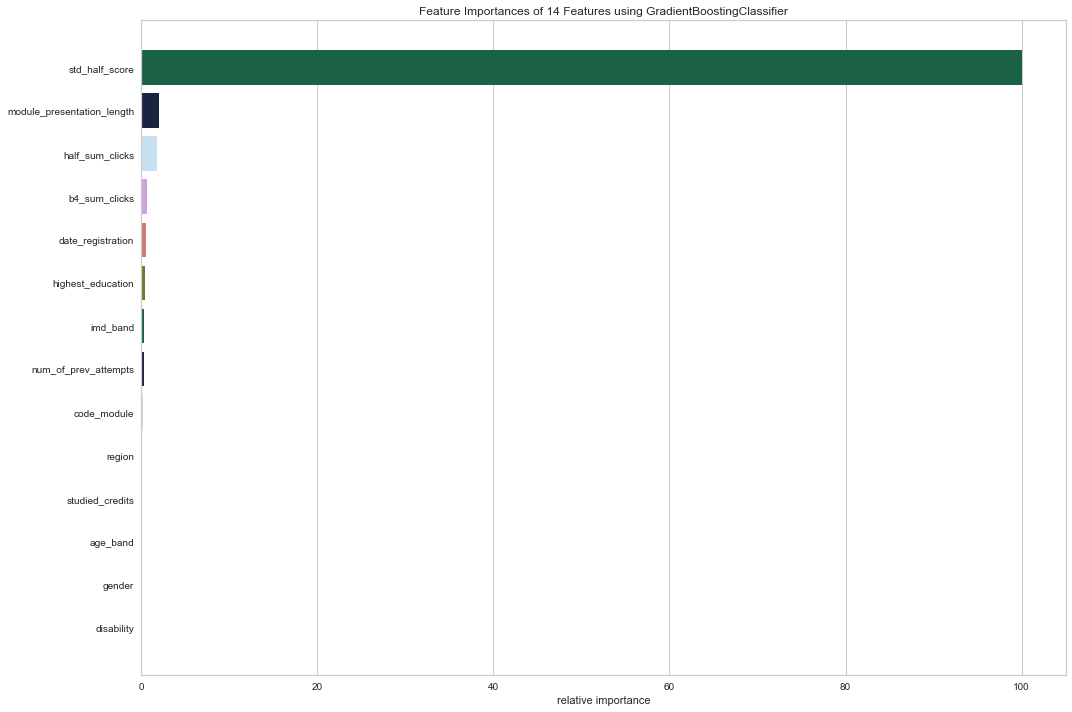

In [19]:
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier()
viz = FeatureImportances(model, size=(1080, 720))
viz.fit(X, y)
viz.show()

SVM Feature Ranking

//anaconda3/lib/python3.7/site-packages/yellowbrick/model_selection/importances.py:195: YellowbrickWarning: detected multi-dimensional feature importances but stack=False, using mean to aggregate them.
  YellowbrickWarning,


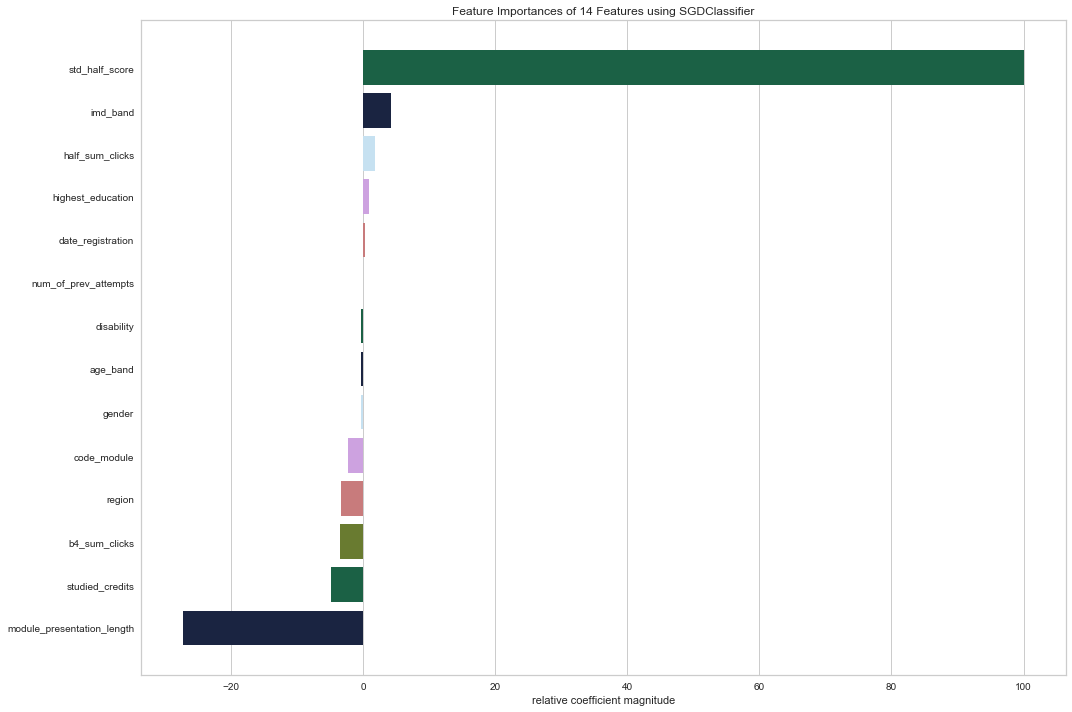

In [20]:
from sklearn import linear_model
model = linear_model.SGDClassifier()
viz = FeatureImportances(model, size=(1080, 720))
viz.fit(X, y)
viz.show()

Lasso Feature Ranking

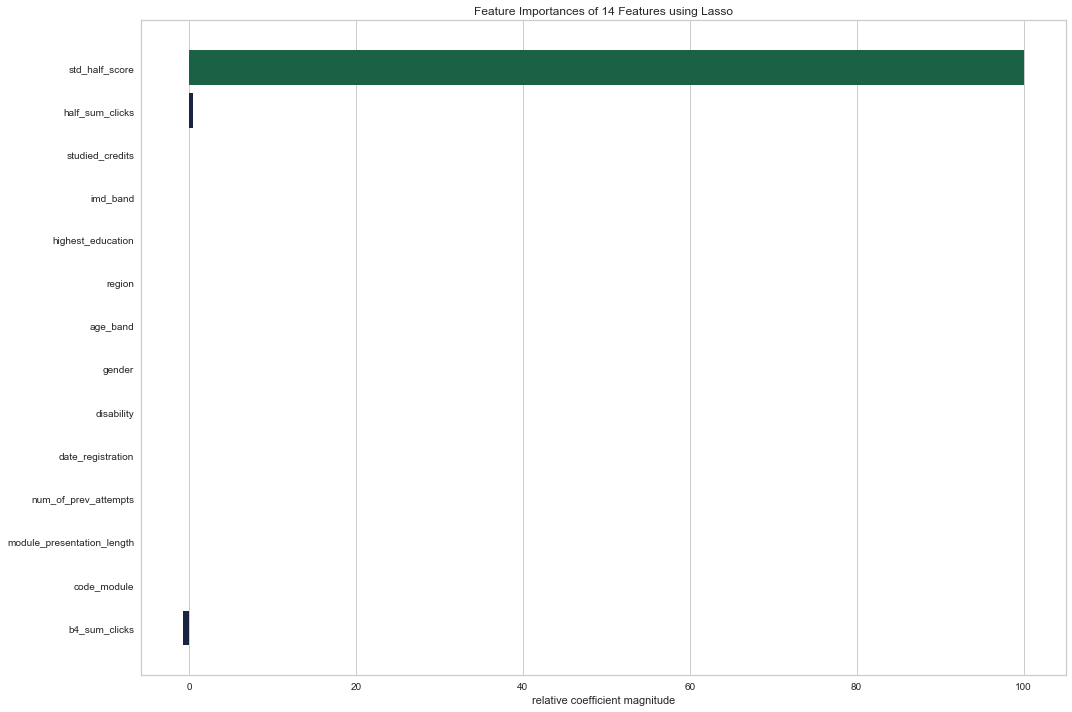

In [21]:
model = Lasso()
viz = FeatureImportances(model, size=(1080, 720))

viz.fit(X, y)
viz.show()

# Additional Feature Analysis

Pearson Squares Feature Ranking (Excludes final_result)

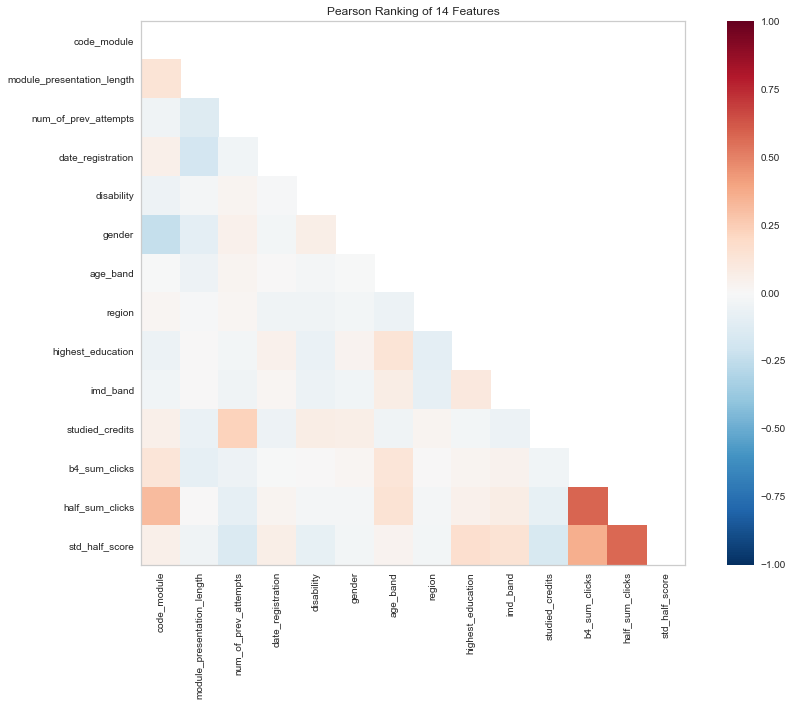

In [22]:
# Instantiate the visualizer with the Pearson ranking algorithm
visualizer = Rank2D(algorithm='pearson', size=(1080, 720))

visualizer.fit(X, y)
visualizer.transform(X)
visualizer.show()

In [23]:
#features = feature_list[feature_list.columns.drop(['final_result'])]
#label = feature_list['final_result']

PCA Decomposition Analysis

//anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
//anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
//anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


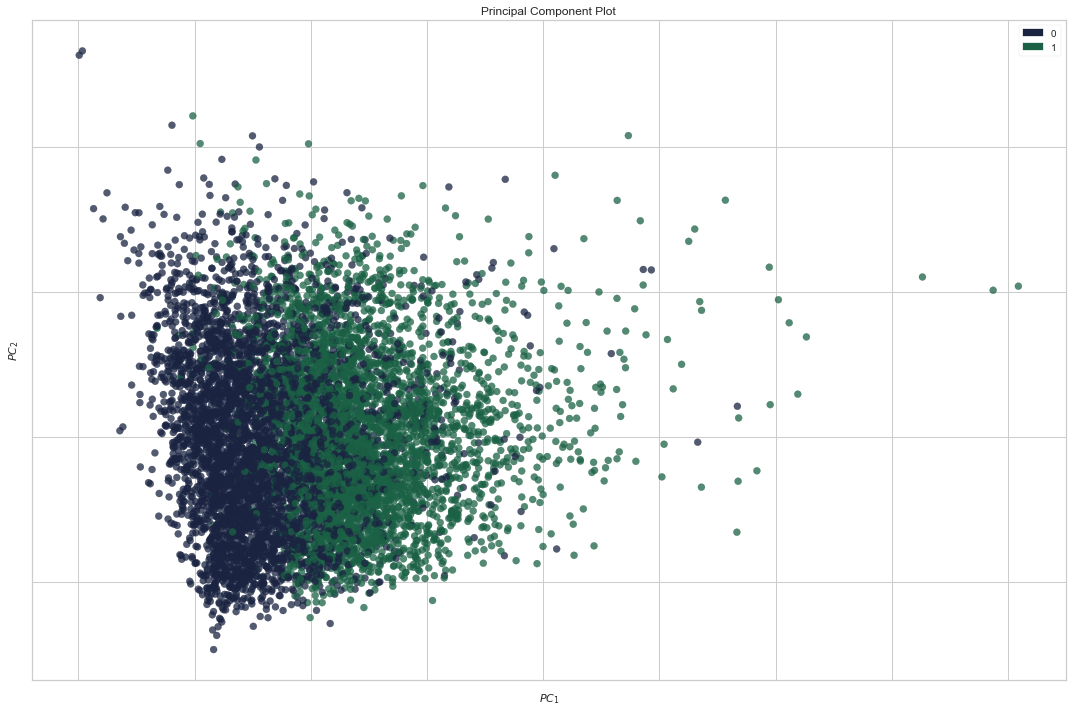

In [24]:
from yellowbrick.features.pca import PCADecomposition

# Create a list of colors to assign to points in the plot
colors = np.array(['r' if yi else 'b' for yi in y])

visualizer = PCADecomposition(
    scale=True, color=colors, size=(1080, 720)
)
visualizer.fit(X, y)
visualizer.transform(X, y)
visualizer.show()

Manifold from Yellowbrick

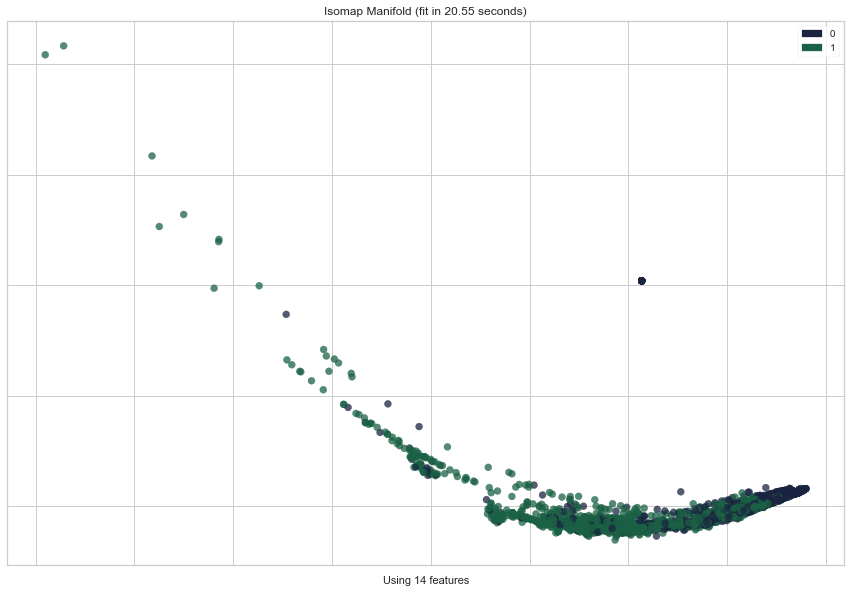

In [25]:
from yellowbrick.features.manifold import Manifold

visualizer = Manifold(
    manifold='isomap', n_neighbors=5, target='continuous', size=(1080, 720)
)
visualizer.fit(X, y)
visualizer.transform(X, y)
visualizer.show()

# Regularization Techniques

In [26]:
features = X
labels   = y

In [27]:
list(features)

['code_module',
 'module_presentation_length',
 'num_of_prev_attempts',
 'date_registration',
 'disability',
 'gender',
 'age_band',
 'region',
 'highest_education',
 'imd_band',
 'studied_credits',
 'b4_sum_clicks',
 'half_sum_clicks',
 'std_half_score']

In [28]:
model = LinearRegression()
model.fit(features, labels)
print(list(zip(features, model.coef_.tolist())))

[('code_module', -0.003871531824192362), ('module_presentation_length', 0.003143950542753715), ('num_of_prev_attempts', 0.010540060656655248), ('date_registration', -0.00017088630617683985), ('disability', 0.006570215190402041), ('gender', -0.0008605306216579197), ('age_band', 0.010629496632903116), ('region', 0.00023550850131219593), ('highest_education', 0.018828353279627258), ('imd_band', 0.003621948949543552), ('studied_credits', 2.616154284874352e-05), ('b4_sum_clicks', -0.00011474333818635427), ('half_sum_clicks', 2.9294641650229065e-05), ('std_half_score', 0.010863295911115406)]


In [29]:
model = Lasso()
model.fit(features, labels)
print(list(zip(features, model.coef_.tolist())))

[('code_module', -0.0), ('module_presentation_length', 0.0), ('num_of_prev_attempts', -0.0), ('date_registration', -0.0), ('disability', -0.0), ('gender', -0.0), ('age_band', 0.0), ('region', -0.0), ('highest_education', 0.0), ('imd_band', 0.0), ('studied_credits', -0.0), ('b4_sum_clicks', -6.399066778437809e-05), ('half_sum_clicks', 4.616905353772545e-05), ('std_half_score', 0.009639209993157984)]


In [30]:
model = Ridge()
model.fit(features, labels)
print(list(zip(features, model.coef_.tolist())))

[('code_module', -0.0038713290374362435), ('module_presentation_length', 0.003143908668079251), ('num_of_prev_attempts', 0.010534219258427955), ('date_registration', -0.00017088703016116577), ('disability', 0.006559639941638691), ('gender', -0.0008590544569461868), ('age_band', 0.010623728368445672), ('region', 0.00023534514578284592), ('highest_education', 0.01882388650260309), ('imd_band', 0.003621969170185353), ('studied_credits', 2.6176992259033638e-05), ('b4_sum_clicks', -0.00011474221669089006), ('half_sum_clicks', 2.9294828691952032e-05), ('std_half_score', 0.010863290058615077)]


In [31]:
model = ElasticNet()
model.fit(features, labels)
print(list(zip(features, model.coef_.tolist())))

[('code_module', -0.0), ('module_presentation_length', 0.0), ('num_of_prev_attempts', -0.0), ('date_registration', -7.80452642663203e-05), ('disability', -0.0), ('gender', -0.0), ('age_band', 0.0), ('region', -0.0), ('highest_education', 0.0), ('imd_band', 0.0), ('studied_credits', -0.0), ('b4_sum_clicks', -0.00010481137448893457), ('half_sum_clicks', 3.898546804453401e-05), ('std_half_score', 0.010264189883493327)]


In [32]:
model = LogisticRegression()
model.fit(features, labels)
print(list(zip(features, model.coef_.tolist())))

[('code_module', [-0.01808574425643939, -0.018827792190895584, -0.00030939771608977596, -0.0018569776774343923, -0.0004170268911721552, -0.008519112833163154, -0.0013882355150726033, -0.017541044938071928, 0.016349384534405726, 0.032823163637646806, -0.0027564789414327895, -0.0012636661977141813, 0.000398601341435429, 0.08180527005586734])]


In [33]:
model = linear_model.SGDClassifier()
model.fit(features, labels)
print(list(zip(features, model.coef_.tolist())))

[('code_module', [-219.89030529189682, -2382.228455508544, 9.016003406045831, -273.48543665005775, -24.293120288512238, -40.82245986626294, -26.046232061910043, -153.0216133637217, 84.14936512309492, 400.7112624909235, -631.1202384231995, -289.7643316887488, 361.89235893711134, 9050.597156443957])]


# Transformer Techniques

In [34]:
model = Lasso()
sfm = SelectFromModel(model)
sfm.fit(features, labels)
print(list(features.iloc[:, sfm.get_support(indices=True)]))

['b4_sum_clicks', 'half_sum_clicks', 'std_half_score']


In [35]:
model = Ridge()
sfm = SelectFromModel(model)
sfm.fit(features, labels)
print(list(features.iloc[:, sfm.get_support(indices=True)]))

['num_of_prev_attempts', 'disability', 'age_band', 'highest_education', 'std_half_score']


In [36]:
model = ElasticNet()
sfm = SelectFromModel(model)
sfm.fit(features, labels)
print(list(features.iloc[:, sfm.get_support(indices=True)]))

['std_half_score']


In [37]:
model = RandomForestClassifier()
sfm = SelectFromModel(model)
sfm.fit(features, labels)
print(list(features.iloc[:, sfm.get_support(indices=True)]))

['b4_sum_clicks', 'half_sum_clicks', 'std_half_score']


In [38]:
model = DecisionTreeClassifier()
sfm = SelectFromModel(model)
sfm.fit(features, labels)
print(list(features.iloc[:, sfm.get_support(indices=True)]))

['half_sum_clicks', 'std_half_score']


In [39]:
model = linear_model.SGDClassifier()
sfm = SelectFromModel(model)
sfm.fit(features, labels)
print(list(features.iloc[:, sfm.get_support(indices=True)]))

['module_presentation_length', 'std_half_score']


# Model Evaluation

In [40]:
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from yellowbrick.classifier import ClassificationReport

In [41]:
train = df
lr = LogisticRegression(random_state=1)

X = train[['code_module', 'module_domain', 'module_presentation_length','year','term', 'num_of_prev_attempts',
                    'date_registration', 'disability', 'gender', 'age_band', 'region', 'highest_education', 
                    'imd_band', 'studied_credits', 'b4_sum_clicks', 'half_sum_clicks', 'std_half_score']]
y = train['final_result']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2)
log_reg = lr.fit(X_train, y_train)

In [42]:
models = [
    SVC(gamma='auto'), NuSVC(gamma='auto'), LinearSVC(),
    SGDClassifier(max_iter=100, tol=1e-3), KNeighborsClassifier(),
    LogisticRegression(solver='lbfgs'), LogisticRegressionCV(cv=3),
    BaggingClassifier(), ExtraTreesClassifier(n_estimators=300),
    RandomForestClassifier(n_estimators=300)
]

In [43]:
def score_model(X_train, y_train, estimator, **kwargs):
    """
    Test various estimators.
    """
    y_train = LabelEncoder().fit_transform(y_train)
    model = Pipeline([
        ('one_hot_encoder', OneHotEncoder(categories = 'auto')),
        ('estimator', estimator)
    ])

    # Instantiate the classification model and visualizer
    model.fit(X_train, y_train, **kwargs)

    expected  = y_train
    predicted = model.predict(X_train)

    # Compute and return F1 (harmonic mean of precision and recall)
    print("{}: {}".format(estimator.__class__.__name__, f1_score(expected, predicted)))

for model in models:
    score_model(X_test, y_test, model)

SVC: 0.6949843260188088
NuSVC: 0.9140198909207571
LinearSVC: 0.9861952861952862
SGDClassifier: 0.9696768848384425
KNeighborsClassifier: 0.7258930223949657
LogisticRegression: 0.9276401564537158


//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
//ana

LogisticRegressionCV: 0.9686771076307897
BaggingClassifier: 0.9873588403842913
ExtraTreesClassifier: 1.0
RandomForestClassifier: 1.0


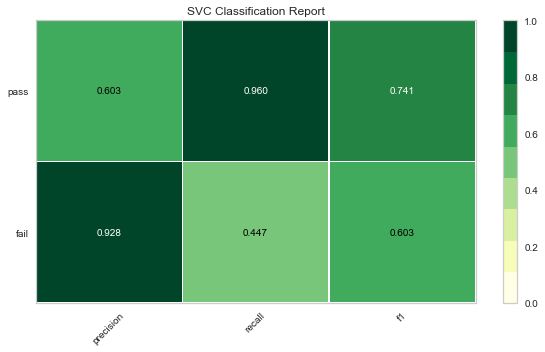

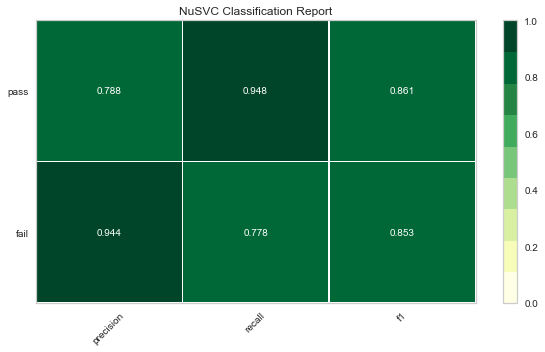

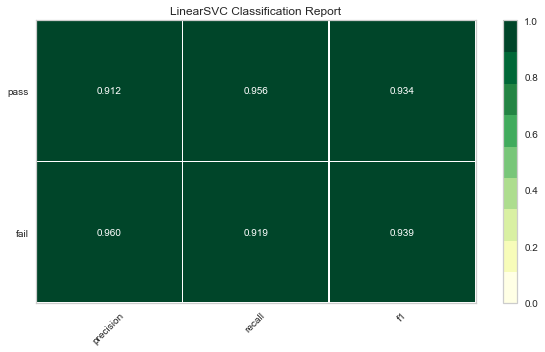

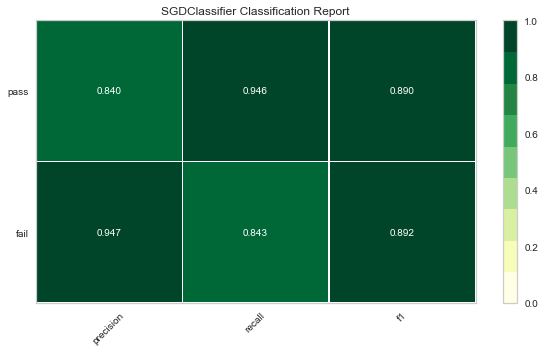

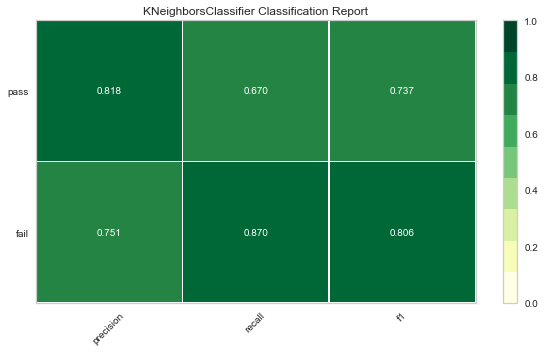

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


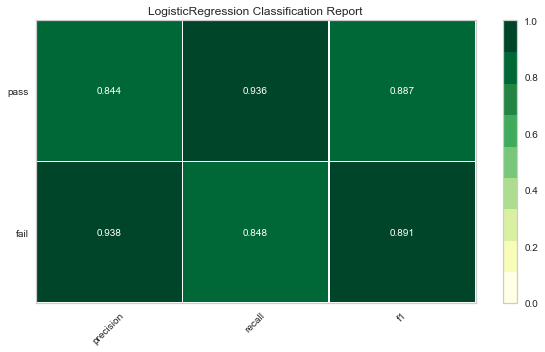

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
//ana

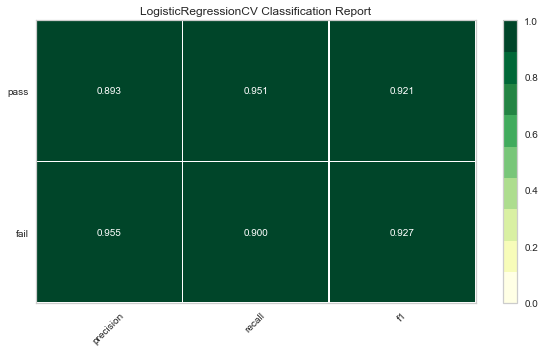

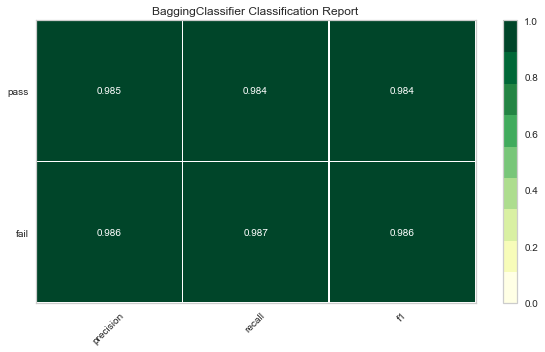

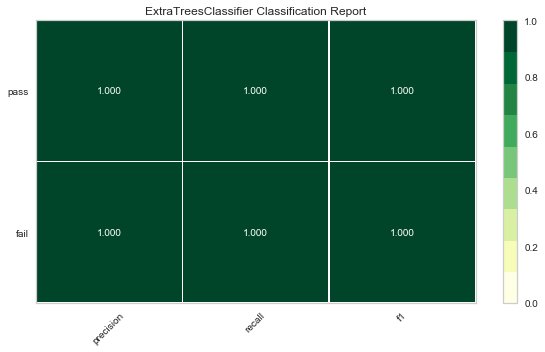

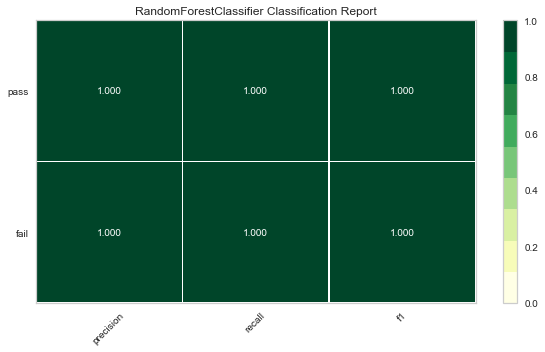

In [56]:
from sklearn.pipeline import Pipeline
from yellowbrick.classifier import ClassificationReport
def visualize_model(X, y, estimator, **kwargs):

    """
    Test various estimators.
    """
    y = LabelEncoder().fit_transform(y)
    model = Pipeline([
    ('one_hot_encoder', OneHotEncoder(categories = 'auto')),
    ('estimator', estimator)
    ])
    # Instantiate the classification model and visualizer
    visualizer = ClassificationReport(
    model, classes=['fail', 'pass'],
    cmap="YlGn", size=(600, 360), **kwargs
    )
    visualizer.fit(X, y)
    visualizer.score(X, y)
    visualizer.show()

for model in models:
    visualize_model(X, y, model)